<a href="https://colab.research.google.com/github/1up9059/Raman_USAF_Analysis/blob/notebooks/PCA_applied_to_RAMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
import os
import csv
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # para activar 3D en matplotlib
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler

import pdb

In [ ]:
!pip install plotly
import plotly.graph_objects as go

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).





PCA for raman spectroscopy:

1. The Raman Spectra tipically have a lot of data.
2. Many band are correlated or they are redundant
3. The shift between Raman spectra is restricted between few dimensions (PC)
4. This allow to visualize trayectories in the characters space

Data used:

SERS_hotspot_Lanmodiluin_plus_Eu(III)_trapeed
Organics_trapped_20Vpp_20-MHz_BL_smooth

## Reading the files

Next code is to read data from a folder inside google drive in folder  Raman_analysis



Routine:

1. We define data separator for reading
2. We define the separator_tracker to detect separators in the files
3. We read the files by using separator_tracker so we can replace the separator to the correct one (,)
4. Headers replace, we replace the headers if the headers are numeric, this condition means there is no headers in the data

In [ ]:
CANDIDATE_SEPS = [',', ';', '\t', '|', ' ']

In [ ]:
def separator_tracker(path: Path, sample_size: int = 4096) -> str:
    """return the most recurrent separator in the file"""
    with path.open('r', newline='') as f:
        sample = f.read(sample_size)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=CANDIDATE_SEPS).delimiter
        return dialect
    except csv.Error:
        # if there i a fail, returns None
        return None

Creating the file reading

In [ ]:
def read_csv_files(folder_path: Path) -> dict:
  """
  Here we read the csv files
  Parameters: folder_path: Path
  """
  folder_path = Path(folder_path)
  csv_files = list(folder_path.glob('*.csv'))
  data_df = {}

  for csv_file in csv_files:
    file_path = csv_file
    try:
      sep = separator_tracker(file_path)
      df = pd.read_csv(file_path, sep=sep, engine='python')
      key = str(csv_file).split('/')[-1].split('.')[0]#take the file name without .csv as key for the dict
      data_df[key] = df
      #print(f"✅ {key} read. Separator: '{repr(sep)}', columnas = {df.shape[1]}")
    except Exception as e:
      print(f"⚠️  Error reading {csv_file}: {e}")

  #Checking the heads of all the dataframes read
  if data_df :
    first_df_key = list(data_df .keys())[0]
    print(f"\nDisplaying head of {first_df_key}:")
    display(data_df[first_df_key].head())
  else:
    print("No CSV files found in the specified folder.")
  return data_df

Creating the file formating

In [ ]:
def headers_replace(df: pd.DataFrame, key: str)-> pd.DataFrame:
  """
  Here we replace the headers
  Parameters: df: pd.DataFrame, key: str
  """
  try:
    old_headers = list(df.columns)
    new_df = pd.concat([pd.DataFrame([old_headers], columns=df.columns), df],ignore_index=True)
    name = key.split('.')[0]
    new_df.columns = ['wavelength', f'intensity_{name}']
    # Convert 'waveleght' column to numeric, coercing errors
    new_df['wavelength'] = pd.to_numeric(new_df['wavelength'], errors='coerce')
    new_df[f'intensity_{name}'] = pd.to_numeric(new_df[f'intensity_{name}'], errors='coerce')

  except Exception as e:
    print(f"⚠️  Error replacing headers: {e}")
  return new_df

def headers_modifier(dfs_dict: dict)-> dict:
  """
  Here we replace the headers
  Parameters: dfs_dict: dict
  """
  for key, df in dfs_dict.items():
    try:
      dfs_dict[key] = headers_replace(df, key)
    except Exception as e:
      print(f"⚠️  Error replacing headers: {e}")
  return dfs_dict
#

## Reading Excution

We indicate the paths were the files are storage as csv.

In [ ]:
folder_1_path = '/content/drive/MyDrive/Raman_analysis/2024.12.17_SERS_hotspot_Lanmodulin_plus_Eu(III)_trapped_16-03_K5_007'
folder_2_path = '/content/drive/MyDrive/Raman_analysis/2024.12.17_SERS_hotspot_Lanmodulin_plus_Eu(III)_trapped_16-03_K5_008'
folder_3_path = '/content/drive/MyDrive/Raman_analysis/Organics_trapped_20Vpp_20-8MHz_BL_smooth'

read all the files for both experiments

In [ ]:
landmodulin007_df = read_csv_files(folder_1_path)
landmodulin008_df = read_csv_files(folder_2_path)
organics_trapped_df = read_csv_files(folder_3_path)


Displaying head of 007_ch4_spec1_BL_and_smooth:


,53.9282,42.1343
0,58.7088,87.299
1,63.4864,110.288
2,68.2626,115.661
3,73.0344,109.894
4,77.8033,102.983



Displaying head of 008_ch4_spec1_BL_and_smooth:


,53.9282,81.4277
0,58.7088,106.487
1,63.4864,119.432
2,68.2626,118.354
3,73.0344,111.874
4,77.8033,103.905



Displaying head of 010_ch3_1:


,50.2637,681.231
0,55.0451,949.220
1,59.8237,1090.410
2,64.5993,1100.380
3,69.3720,1055.130
4,74.1417,987.658


We modify the header to

In [ ]:
landmodulin007_df = headers_modifier(landmodulin007_df)
landmodulin008_df = headers_modifier(landmodulin008_df)
organics_trapped_df = headers_modifier(organics_trapped_df)

In [ ]:
landmodulin007_df

{'007_ch4_spec1_BL_and_smooth':      wavelength  intensity_007_ch4_spec1_BL_and_smooth
 0       53.9282                               42.13430
 1       58.7088                               87.29900
 2       63.4864                              110.28800
 3       68.2626                              115.66100
 4       73.0344                              109.89400
 ..          ...                                    ...
 963   3587.8300                                7.55875
 964   3590.6200                                8.70141
 965   3593.4100                                6.32207
 966   3596.2000                                5.18344
 967   3598.9800                                4.61718
 
 [968 rows x 2 columns],
 '007_ch4_spec2_BL_and_smooth':      wavelength  intensity_007_ch4_spec2_BL_and_smooth
 0       53.9282                               84.59070
 1       58.7088                              122.29300
 2       63.4864                              140.63100
 3       68.262

In [ ]:
df_ex1 = landmodulin007_df[list(landmodulin007_df.keys())[0]]
df_ex2 = landmodulin008_df[list(landmodulin008_df.keys())[0]]
df_ex3 = organics_trapped_df[list(organics_trapped_df.keys())[0]]

## Data Frames EDA

I am creating and **EDA** function review the completeness for all the read dataframes

In [ ]:
def df_EDA(df_dicts : dict):
  '''
  This function is making a basic EDA to all the readed dataframes after chage the original headers
  Parameters: df_dicts: dict
  '''
  for key, df in df_dicts.items():
    print("-"*50)
    print(f"Dataframe name: {key}")
    print(f"HEAD:")
    print(df.head())
    print(f"\n")
    print(f"INFO:")
    print(df.info())
    print(f"\n")
    print(f"NULLS:")
    print(df.isnull().sum())
    print(f"\n")
    print(f"NAN:")
    print(df.isna().sum())
    print(f"\n")
    print(f"SHAPE:")
    print(df.shape)
    print("-"*50)


In [ ]:
df_EDA(df_dicts = landmodulin007_df)

--------------------------------------------------
Dataframe name: 007_ch4_spec1_BL_and_smooth
HEAD:
   wavelength  intensity_007_ch4_spec1_BL_and_smooth
0     53.9282                                42.1343
1     58.7088                                87.2990
2     63.4864                               110.2880
3     68.2626                               115.6610
4     73.0344                               109.8940


INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 2 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   wavelength                             968 non-null    float64
 1   intensity_007_ch4_spec1_BL_and_smooth  968 non-null    float64
dtypes: float64(2)
memory usage: 15.3 KB
None


NULLS:
wavelength                               0
intensity_007_ch4_spec1_BL_and_smooth    0
dtype: int64


NAN:
wavelength                          

In [ ]:
df_EDA(df_dicts = landmodulin008_df)

--------------------------------------------------
Dataframe name: 008_ch4_spec1_BL_and_smooth
HEAD:
   wavelength  intensity_008_ch4_spec1_BL_and_smooth
0     53.9282                                81.4277
1     58.7088                               106.4870
2     63.4864                               119.4320
3     68.2626                               118.3540
4     73.0344                               111.8740


INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 2 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   wavelength                             968 non-null    float64
 1   intensity_008_ch4_spec1_BL_and_smooth  968 non-null    float64
dtypes: float64(2)
memory usage: 15.3 KB
None


NULLS:
wavelength                               0
intensity_008_ch4_spec1_BL_and_smooth    0
dtype: int64


NAN:
wavelength                          

In [ ]:
df_EDA(df_dicts = organics_trapped_df)

--------------------------------------------------
Dataframe name: 010_ch3_1
HEAD:
   wavelength  intensity_010_ch3_1
0     50.2637              681.231
1     55.0451              949.220
2     59.8237             1090.410
3     64.5993             1100.380
4     69.3720             1055.130


INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   wavelength           969 non-null    float64
 1   intensity_010_ch3_1  969 non-null    float64
dtypes: float64(2)
memory usage: 15.3 KB
None


NULLS:
wavelength             0
intensity_010_ch3_1    0
dtype: int64


NAN:
wavelength             0
intensity_010_ch3_1    0
dtype: int64


SHAPE:
(969, 2)
--------------------------------------------------
--------------------------------------------------
Dataframe name: 010_ch3_2
HEAD:
   wavelength  intensity_010_ch3_2
0     50.2637       

In summey for **Landmodlin + Eu(III)** we have 969 intesity values in the specific rage of the wavelength used for the mesuements. And the same for the other experiments

# Full dataframe creation

In this section I will create a complete dataframe with data from all spectra. The used structure of this dataframe is: first column as *wave number* column, and the others will be the colums related with the *intensity* of all the spectra. In this case this will allow us to normalize all the spectrometic data taking as reference all spectra. Also, by this way, we will be able to apply any cleaning technique to all the intensity columns checking any shift in the peaks for the spectra, been able to solve many issues that can arise from anomalies or measurement problems that can be minimized

In [ ]:
for key, df in organics_trapped_df.items():
  print(key, df.shape)

010_ch3_1 (969, 2)
010_ch3_2 (969, 2)
010_ch3_3 (969, 2)
010_ch3_4 (969, 2)
010_ch3_5 (969, 2)
010_ch3_6 (969, 2)
013_ch7_1 (969, 2)
013_ch7_2 (969, 2)
013_ch7_3 (969, 2)
013_ch7_4 (969, 2)
013_ch7_5 (969, 2)
013_ch7_6 (969, 2)


In [ ]:
for key, df in landmodulin008_df.items():
  print(key, df.shape)

008_ch4_spec1_BL_and_smooth (968, 2)
008_ch4_spec2_BL_and_smooth (968, 2)
008_ch4_spec3_BL_and_smooth (968, 2)
008_ch4_spec4_BL_and_smooth (968, 2)
008_ch4_spec5_BL_and_smooth (968, 2)
008_ch4_spec6_BL_and_smooth (968, 2)
008_ch4_spec7_BL_and_smooth (968, 2)
008_ch4_spec8_BL_and_smooth (968, 2)
008_ch4_spec9_BL_and_smooth (968, 2)
008_ch4_spec10_BL_and_smooth (968, 2)
008_ch4_spec11_BL_and_smooth (968, 2)
008_ch4_spec13_BL_and_smooth (968, 2)
008_ch4_spec14_BL_and_smooth (968, 2)
008_ch4_spec15_spot_avg_BL_and_smooth (968, 2)
008_ch4_spec16_BL_and_smooth (968, 2)
008_ch4_spec17_BL_and_smooth (968, 2)
008_ch4_spec18_BL_and_smooth (968, 2)
008_ch4_spec19_BL_and_smooth (968, 2)
008_ch4_spec21_BL_and_smooth (968, 2)
008_ch4_spec20_BL_and_smooth (968, 2)
008_ch4_spec22_BL_and_smooth (968, 2)
008_ch4_spec23_BL_and_smooth (968, 2)


In [ ]:
def stack_spectra_merge(dfs_dict: dict) -> pd.DataFrame:
  """
  here we convine the dataframes for each spectra base on the wavelength column
  and using all the intensity columns
  Parameters:
  """
  merged = None

  for key, df in dfs_dict.items():
    #pdb.set_trace()
    df_tmp = df.loc[:,list(df.columns)[1]]

    if merged is None:
      merged = df.copy()
    else:
      merged[list(df.columns)[1]] = df_tmp

  return merged



Creating *full_dataframe* for **full_data_landmodulin007_df**

In [ ]:
fd_landmodulin007_df = stack_spectra_merge(dfs_dict=landmodulin007_df)

In [ ]:
fd_landmodulin007_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   wavelength                              968 non-null    float64
 1   intensity_007_ch4_spec1_BL_and_smooth   968 non-null    float64
 2   intensity_007_ch4_spec2_BL_and_smooth   968 non-null    float64
 3   intensity_007_ch4_spec3_BL_and_smooth   968 non-null    float64
 4   intensity_007_ch4_spec4_BL_and_smooth   968 non-null    float64
 5   intensity_007_ch4_spec5_BL_and_smooth   968 non-null    float64
 6   intensity_007_ch4_spec6_BL_and_smooth   968 non-null    float64
 7   intensity_007_ch4_spec7_BL_and_smooth   968 non-null    float64
 8   intensity_007_ch4_spec8_BL_and_smooth   968 non-null    float64
 9   intensity_007_ch4_spec9_BL_and_smooth   968 non-null    float64
 10  intensity_007_ch4_spec10_BL_and_smooth  968 non-null    float6

In [ ]:
fd_landmodulin007_df.columns

Index(['wavelength', 'intensity_007_ch4_spec1_BL_and_smooth',
       'intensity_007_ch4_spec2_BL_and_smooth',
       'intensity_007_ch4_spec3_BL_and_smooth',
       'intensity_007_ch4_spec4_BL_and_smooth',
       'intensity_007_ch4_spec5_BL_and_smooth',
       'intensity_007_ch4_spec6_BL_and_smooth',
       'intensity_007_ch4_spec7_BL_and_smooth',
       'intensity_007_ch4_spec8_BL_and_smooth',
       'intensity_007_ch4_spec9_BL_and_smooth',
       'intensity_007_ch4_spec10_BL_and_smooth',
       'intensity_007_ch4_spec11_BL_and_smooth',
       'intensity_007_ch4_spec12_BL_and_smooth',
       'intensity_007_ch4_spec13_BL_and_smooth',
       'intensity_007_ch4_spec14_BL_and_smooth',
       'intensity_007_ch4_spec15_BL_and_smooth',
       'intensity_007_ch4_spec16_BL_and_smooth'],
      dtype='object')

In [ ]:
fd_landmodulin007_df.head()

,wavelength,intensity_007_ch4_spec1_BL_and_smooth,intensity_007_ch4_spec2_BL_and_smooth,intensity_007_ch4_spec3_BL_and_smooth,intensity_007_ch4_spec4_BL_and_smooth,intensity_007_ch4_spec5_BL_and_smooth,intensity_007_ch4_spec6_BL_and_smooth,intensity_007_ch4_spec7_BL_and_smooth,intensity_007_ch4_spec8_BL_and_smooth,intensity_007_ch4_spec9_BL_and_smooth,intensity_007_ch4_spec10_BL_and_smooth,intensity_007_ch4_spec11_BL_and_smooth,intensity_007_ch4_spec12_BL_and_smooth,intensity_007_ch4_spec13_BL_and_smooth,intensity_007_ch4_spec14_BL_and_smooth,intensity_007_ch4_spec15_BL_and_smooth,intensity_007_ch4_spec16_BL_and_smooth
0,53.9282,42.1343,84.5907,96.0933,106.273,85.1784,85.2485,44.5628,73.0867,59.8138,114.661,150.238,30.9096,-2.860140,19.8185,22.7136,37.0367
1,58.7088,87.2990,122.2930,138.1690,171.224,136.5050,131.6320,78.5987,121.8930,101.7510,164.783,190.918,37.7429,0.290503,21.6818,31.6151,39.2055
2,63.4864,110.2880,140.6310,158.5960,205.240,166.9040,156.0480,97.3471,148.1870,122.6050,190.804,213.988,37.8128,1.804220,23.9320,33.6610,39.9529
3,68.2626,115.6610,143.2310,159.0050,203.366,172.8510,158.4930,102.6150,152.0780,118.8580,192.276,215.286,37.5052,3.103110,23.6198,33.4298,41.9514
4,73.0344,109.8940,137.2330,152.4440,195.505,165.0960,152.7750,95.6371,143.6510,112.6060,183.385,205.468,36.1525,1.331010,22.4606,30.8276,41.5814


Creating *full_dataframe* for **full_data_landmodulin008_df**

In [ ]:
fd_landmodulin008_df = stack_spectra_merge(dfs_dict=landmodulin008_df)

In [ ]:
fd_landmodulin008_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 23 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   wavelength                                       968 non-null    float64
 1   intensity_008_ch4_spec1_BL_and_smooth            968 non-null    float64
 2   intensity_008_ch4_spec2_BL_and_smooth            968 non-null    float64
 3   intensity_008_ch4_spec3_BL_and_smooth            968 non-null    float64
 4   intensity_008_ch4_spec4_BL_and_smooth            968 non-null    float64
 5   intensity_008_ch4_spec5_BL_and_smooth            968 non-null    float64
 6   intensity_008_ch4_spec6_BL_and_smooth            968 non-null    float64
 7   intensity_008_ch4_spec7_BL_and_smooth            968 non-null    float64
 8   intensity_008_ch4_spec8_BL_and_smooth            968 non-null    float64
 9   intensity_008_ch4_spec9_BL_and_s

In [ ]:
fd_landmodulin008_df.columns

Index(['wavelength', 'intensity_008_ch4_spec1_BL_and_smooth',
       'intensity_008_ch4_spec2_BL_and_smooth',
       'intensity_008_ch4_spec3_BL_and_smooth',
       'intensity_008_ch4_spec4_BL_and_smooth',
       'intensity_008_ch4_spec5_BL_and_smooth',
       'intensity_008_ch4_spec6_BL_and_smooth',
       'intensity_008_ch4_spec7_BL_and_smooth',
       'intensity_008_ch4_spec8_BL_and_smooth',
       'intensity_008_ch4_spec9_BL_and_smooth',
       'intensity_008_ch4_spec10_BL_and_smooth',
       'intensity_008_ch4_spec11_BL_and_smooth',
       'intensity_008_ch4_spec13_BL_and_smooth',
       'intensity_008_ch4_spec14_BL_and_smooth',
       'intensity_008_ch4_spec15_spot_avg_BL_and_smooth',
       'intensity_008_ch4_spec16_BL_and_smooth',
       'intensity_008_ch4_spec17_BL_and_smooth',
       'intensity_008_ch4_spec18_BL_and_smooth',
       'intensity_008_ch4_spec19_BL_and_smooth',
       'intensity_008_ch4_spec21_BL_and_smooth',
       'intensity_008_ch4_spec20_BL_and_smooth',
      

In [ ]:
fd_landmodulin008_df.head()

,wavelength,intensity_008_ch4_spec1_BL_and_smooth,intensity_008_ch4_spec2_BL_and_smooth,intensity_008_ch4_spec3_BL_and_smooth,intensity_008_ch4_spec4_BL_and_smooth,intensity_008_ch4_spec5_BL_and_smooth,intensity_008_ch4_spec6_BL_and_smooth,intensity_008_ch4_spec7_BL_and_smooth,intensity_008_ch4_spec8_BL_and_smooth,intensity_008_ch4_spec9_BL_and_smooth,intensity_008_ch4_spec10_BL_and_smooth,intensity_008_ch4_spec11_BL_and_smooth,intensity_008_ch4_spec13_BL_and_smooth,intensity_008_ch4_spec14_BL_and_smooth,intensity_008_ch4_spec15_spot_avg_BL_and_smooth,intensity_008_ch4_spec16_BL_and_smooth,intensity_008_ch4_spec17_BL_and_smooth,intensity_008_ch4_spec18_BL_and_smooth,intensity_008_ch4_spec19_BL_and_smooth,intensity_008_ch4_spec21_BL_and_smooth,intensity_008_ch4_spec20_BL_and_smooth,intensity_008_ch4_spec22_BL_and_smooth,intensity_008_ch4_spec23_BL_and_smooth
0,53.9282,81.4277,58.9397,87.5644,99.7098,143.855,120.207,122.387,98.9102,113.968,109.418,109.418,131.099,85.5249,124.383,127.398,150.997,144.998,163.724,138.774,94.2018,92.0596,94.8183
1,58.7088,106.4870,83.3015,120.0950,135.7610,194.756,172.555,169.498,147.2470,165.960,154.736,154.736,169.058,130.3660,162.552,168.804,212.995,198.443,211.818,192.966,134.0740,152.2490,158.0140
2,63.4864,119.4320,95.1562,136.9410,154.4830,220.761,195.851,190.320,173.5130,189.491,178.160,178.160,187.746,154.4220,181.515,187.409,247.163,225.903,237.802,218.810,156.3100,183.8730,194.1020
3,68.2626,118.3540,94.8652,136.2800,152.9440,218.895,195.603,188.492,173.8370,186.694,178.749,178.749,186.528,156.1700,180.823,184.104,248.913,225.905,237.269,212.429,160.9610,187.7300,198.8120
4,73.0344,111.8740,88.2503,128.4210,144.0800,203.249,183.762,173.439,167.6770,175.479,168.853,168.853,176.424,149.3020,171.052,175.199,234.861,215.379,224.889,201.600,155.5800,177.9510,189.1170


Creating *full_dataframe* for **organics_trapped_df**

In [ ]:
fd_organics_trapped_df = stack_spectra_merge(dfs_dict=organics_trapped_df )

In [ ]:
fd_organics_trapped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   wavelength           969 non-null    float64
 1   intensity_010_ch3_1  969 non-null    float64
 2   intensity_010_ch3_2  969 non-null    float64
 3   intensity_010_ch3_3  969 non-null    float64
 4   intensity_010_ch3_4  969 non-null    float64
 5   intensity_010_ch3_5  969 non-null    float64
 6   intensity_010_ch3_6  969 non-null    float64
 7   intensity_013_ch7_1  969 non-null    float64
 8   intensity_013_ch7_2  969 non-null    float64
 9   intensity_013_ch7_3  969 non-null    float64
 10  intensity_013_ch7_4  969 non-null    float64
 11  intensity_013_ch7_5  969 non-null    float64
 12  intensity_013_ch7_6  969 non-null    float64
dtypes: float64(13)
memory usage: 98.5 KB


In [ ]:
fd_organics_trapped_df.columns

Index(['wavelength', 'intensity_010_ch3_1', 'intensity_010_ch3_2',
       'intensity_010_ch3_3', 'intensity_010_ch3_4', 'intensity_010_ch3_5',
       'intensity_010_ch3_6', 'intensity_013_ch7_1', 'intensity_013_ch7_2',
       'intensity_013_ch7_3', 'intensity_013_ch7_4', 'intensity_013_ch7_5',
       'intensity_013_ch7_6'],
      dtype='object')

In [ ]:
fd_organics_trapped_df.head()

,wavelength,intensity_010_ch3_1,intensity_010_ch3_2,intensity_010_ch3_3,intensity_010_ch3_4,intensity_010_ch3_5,intensity_010_ch3_6,intensity_013_ch7_1,intensity_013_ch7_2,intensity_013_ch7_3,intensity_013_ch7_4,intensity_013_ch7_5,intensity_013_ch7_6
0,50.2637,681.231,694.018,1419.60,1406.04,941.667,1798.82,235.529,261.747,202.376,259.485,292.861,346.630
1,55.0451,949.220,971.842,2156.52,2005.18,1257.700,2195.33,378.028,325.508,259.919,325.518,392.829,407.894
2,59.8237,1090.410,1156.910,2584.13,2328.17,1434.360,2385.02,455.430,362.899,289.661,357.527,446.357,436.704
3,64.5993,1100.380,1158.780,2680.49,2358.60,1441.470,2341.08,467.842,358.385,285.879,355.017,447.903,424.199
4,69.3720,1055.130,1128.490,2609.26,2234.14,1366.040,2229.16,466.111,341.588,275.812,331.890,421.843,402.767


In [ ]:
fd_dataframes_dict = {'fd_landmodulin007_df': fd_landmodulin007_df,
                      'fd_landmodulin008_df': fd_landmodulin008_df,
                      'fd_organics_trapped_df': fd_organics_trapped_df}

## Initial graph for data variation

Here I am creating some function dedicate to create initial plot for spectra time variation. The first one to create static plots, while the second one is to create interactive plot

In [ ]:
def plot_raman_3d(df: pd.DataFrame, tiempo_ini=0, dt=1):
    """
    Draw the raman spectra time evolution in 3D.
    - tiempo_ini  : initial time for the series (por defecto 0)
    - dt          : Time interval (s)
    """
    # 1. Eje X → wavelength
    x_vals = df['wavelength'].values                              # (n_λ,)

    # 2. Eje Z → Intensity (matrix n_spectrum × n_λ)
    intens_cols = [c for c in df.columns if c.startswith('intensity_')]
    Z = df[intens_cols].to_numpy().T                              # shape (n_espectros, n_λ)
    Zs = gaussian_filter(Z, sigma=1.5)

    # 3. Eje Y → tiempo
    tiempos = tiempo_ini + dt * np.arange(Zs.shape[0])             # (n_spectrum,)

    # 4. 2D grid creation for the graph surface
    XX, YY = np.meshgrid(x_vals, tiempos)                         # both (n_espectrum, n_λ)

    # 5. 3D graph creation
    fig = plt.figure(figsize=(11, 7))
    ax  = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(XX, YY, Zs, cmap='viridis', linewidth=0, antialiased=False)

    # Etiquetas y título
    ax.set_xlabel('Wave number (cm^-1)')
    ax.set_ylabel('Time (s)')
    ax.set_zlabel('Intensity')
    ax.set_title('Temporal evolution of Raman spectrum')

    # Barra de color
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Intensity')

    plt.tight_layout()
    plt.show()



In [ ]:
def plot_raman_3d_interactive(df, tiempo_ini=0, dt=1):
    """
    Draw the raman spectra time evolution in 3D.
    - tiempo_ini  : initial time for the series (por defecto 0)
    - dt          : Time interval (s)
    """
    # 1. Eje X → longitudes de onda
    x_vals = df['wavelength'].values                              # (n_λ,)

    # 2. Eje Z → intensidades (matriz n_espectros × n_λ)
    intens_cols = [c for c in df.columns if c.startswith('intensity_')]
    Z = df[intens_cols].to_numpy().T                              # shape (n_espectros, n_λ)

    # 3. Eje Y → tiempo
    tiempos = tiempo_ini + dt * np.arange(Z.shape[0])             # (n_spectrum,)

    # 4. Crear mallas 2D para la superficie
    YY, XX = np.meshgrid(x_vals, tiempos)                          # both (n_espectrum, n_λ)
    # 5. Crear figura interactiva con Plotly
    fig = go.Figure(data=[go.Surface(
        x=XX,
        y=YY,
        z=Z,
        colorscale='Viridis',
        colorbar=dict(title='Intensidad')
    )])

    fig.update_layout(
        title='Evolución temporal de espectros Raman',
        scene=dict(
            xaxis_title='Tiempo (s)',
            yaxis_title='Wave Number (cm^-1)',
            zaxis_title='Intensidad'
        ),
        autosize=True,
        height=700
    )

    fig.show()

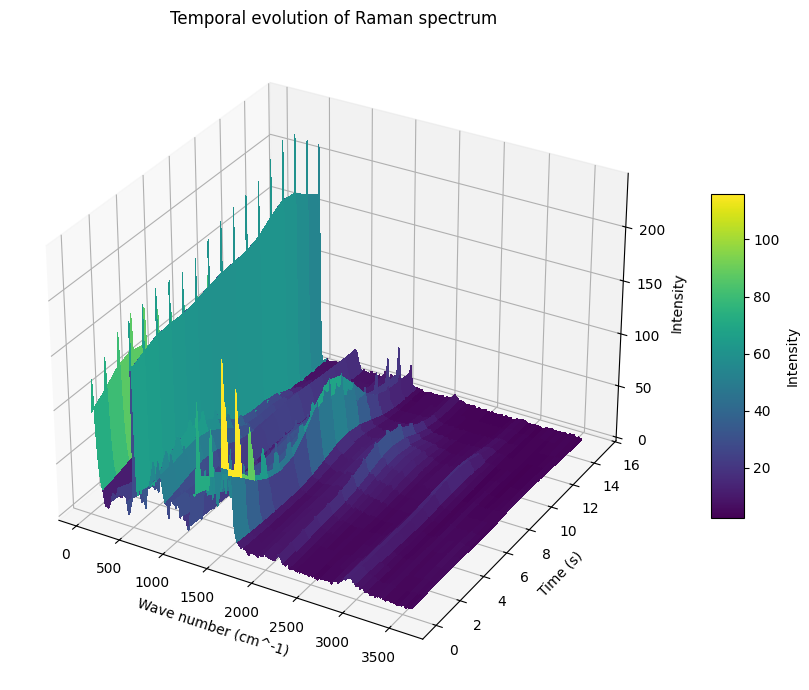

In [ ]:
plot_raman_3d(fd_landmodulin007_df, tiempo_ini=0, dt=1)

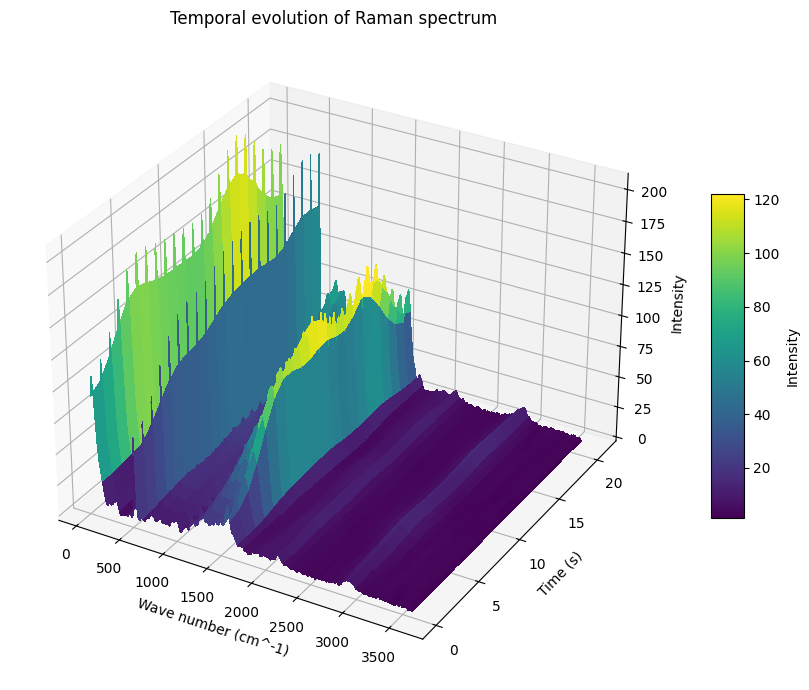

In [ ]:
plot_raman_3d(fd_landmodulin008_df, tiempo_ini=0, dt=1)

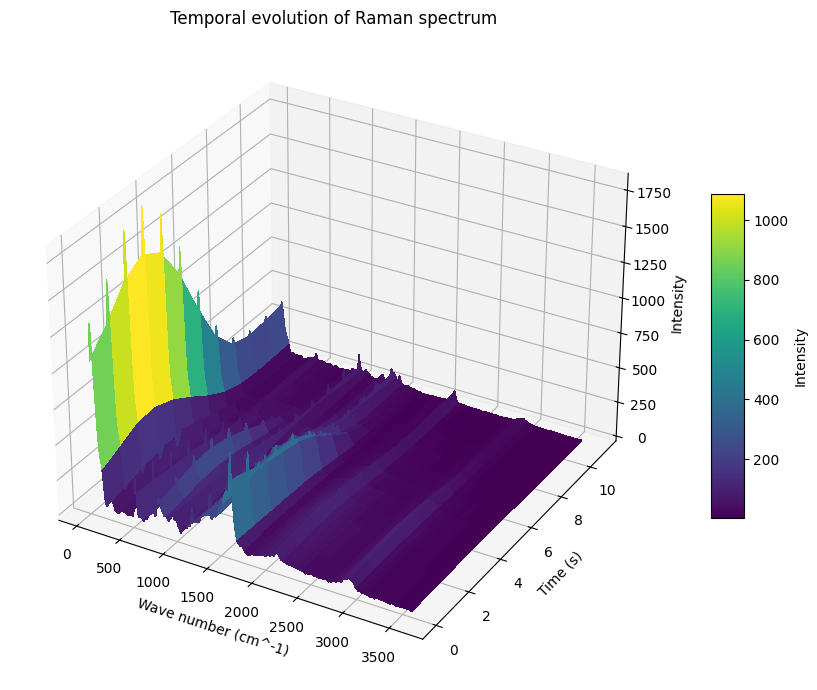

In [ ]:
plot_raman_3d(fd_organics_trapped_df, tiempo_ini=0, dt=1)

###Interactive plots

In [ ]:
plot_raman_3d_interactive(fd_landmodulin007_df)

In [ ]:
plot_raman_3d_interactive(fd_landmodulin008_df)

In [ ]:
plot_raman_3d_interactive(fd_organics_trapped_df)

# PCA Application to full dataframes

To apply PCA we will use Pytorch by implementing PCA from scratch and after the we will implement PAC by sklearn to compare results. This is importan so we can be sure that our implementation is correct. Also, implementing PCA from scratch allow us to control all the features of the process

## Test for Lanmodulin + Eu(III)

Coverting to pytorch tensor:

In [ ]:
lamdmodulin007_df = fd_dataframes_dict['fd_landmodulin007_df']
lamdmodulin007_df.iloc[1:,1]

,intensity_007_ch4_spec1_BL_and_smooth
1,87.29900
2,110.28800
3,115.66100
4,109.89400
5,102.98300
...,...
963,7.55875
964,8.70141
965,6.32207
966,5.18344


We take the dataframe to calculate the covariace matrix for PCA. We drop the "wavelength" colomun is drop due to this is something that doesn't variate on each spectra. Also we need to transpose the matrix since we want to apply PCA over the specters.

Why?:
1. The wavelength column is not a variable feature of spectra.
2. It is constant for all spectra: it is the x-axis (wavelengths), not part of the measurements.
3. PCA is applied to dimensions that vary between observations, and wavelength does not vary between rows or columns.

Next funtion convert a pandas dataframe into a pytorch tensor. I center the data and separate the wavelenght variable, returning both as different tensors

In [ ]:
def torch_conversion(df: pd.DataFrame, scale=False, device="cpu") -> dict:
  df = df.select_dtypes(include=['number'])
  df = df.fillna(0)
  #I transform the data to wavelength tensor and intensity tensor
  wavelengths = torch.tensor(df['wavelength'].values, dtype=torch.float32)
  X = torch.tensor(df.drop(columns=['wavelength']).T.values, dtype=torch.float32)
  #I transform the tensors to use cuda
  wavelengths = wavelengths.to(device, torch.float32)
  X = X.to(device, torch.float32)
  #1.I center the data
  meam = X.mean(dim=0, keepdim=True)
  X_centered = X - meam
  if scale:
    std = X_centered.std(dim=0, unbiased=False, keepdim=True)
    std[std==0] = 1.0
    X_centered /= std
  #2.I compute the covariance matrix
  return {'Lambda': wavelengths, 'I_centered':X_centered, 'I': X}

We sould center the data my substracting the mean from the data, because if we don't do that the covariance matrix is not correct. The PCA does not reflect the true structure of the data. We ae calculating the covariance matrix arrond the mean value

Next function calculate the covarianse matrix needed for PCA calculation

In [ ]:
def torch_cov_matrix_calc(X_centered: torch.Tensor) -> torch.Tensor:
  C = X_centered.T @ X_centered / (X_centered.shape[0] - 1)
  return C


Next funtion calculate the eigenvectors and eigenvalues from the covariance matrix. The function returns the eigenvalues and eigenvectors sorted form major to minor so PC1 will the bigest PC always

In [ ]:
def torch_eigencalculation(X_centerd: torch.Tensor, scale=True)-> tuple:
  eigenvalues, eigenvectors = torch.linalg.eigh(X_centerd)#We get the values from minor to major
  idx = eigenvalues.argsort(descending=True)#We order eigenvectors from major to minor to have PC1 as major variance
  eigenvalues = eigenvalues[idx]
  eigenvectors = eigenvectors[:,idx]
  return (eigenvalues, eigenvectors)

Next function is to apply PCA to the centered data calculated during the beggining. The PCA is just a projection made by the eigenvector matrix obtained from the eigenvector calculation form the covariance matrix. We take the parameter k as the number of vector which we want to use to project our data

In [ ]:
def torch_PCA(X_centered: torch.Tensor, eigenvalues: torch.Tensor, eigenvectors: torch.Tensor, k: int) -> torch.Tensor:
  evals_k = eigenvalues[:k]
  V_k = eigenvectors[:,:k]
  X_proj = X_centered @ V_k
  return X_proj, evals_k

For plot purposes, we can scalate the result in a range [0,1], next funtion is to be able to do that

In [ ]:
def min_max_scaler(X: torch.Tensor) -> torch.Tensor:
  '''
  This funtion is just for visualization purposes
  It is not necessary for PCA, and shouldn't be used if I want to reconstruct the original data
  '''
  X_min = X.min(dim=0, keepdim=True)[0]
  X_max = X.max(dim=0, keepdim=True)[0]
  X_scaled = (X - X_min) / (X_max - X_min)
  return X_scaled

In [ ]:
df_ex1

,wavelength,intensity_007_ch4_spec1_BL_and_smooth
0,53.9282,42.13430
1,58.7088,87.29900
2,63.4864,110.28800
3,68.2626,115.66100
4,73.0344,109.89400
...,...,...
963,3587.8300,7.55875
964,3590.6200,8.70141
965,3593.4100,6.32207
966,3596.2000,5.18344


# PCA execution

1. We starw by getting the Lambda values and intensity tensors form the used dataframe. In this cases as example is *lamdmodulin007*

In [ ]:
lambda1 = torch_conversion(lamdmodulin007_df)['Lambda']
I1_centered = torch_conversion(lamdmodulin007_df)['I_centered']
I1_original = torch_conversion(lamdmodulin007_df)['I']

2. We calculate the covariance matrix

In [ ]:
I1_covariance = torch_cov_matrix_calc(I1_centered)

3. We calculate the eigenvalues and eigenvector from the covariance Matrix

In [ ]:
I1_eigenvalues, I1_eigenvectors = torch_eigencalculation(I1_covariance)

4. We apply the PCA method to project the original data to reduce the dimensionality or just to study the covariance for each of this wavelength between the different spectra.

In [ ]:
pr_I1, evals_k = torch_PCA(I1_centered, I1_eigenvalues, I1_eigenvectors, 2)

In [ ]:
pr_I1

tensor([[-1101.1393,  -463.1423],
        [  -48.7852,    91.9554],
        [   16.8411,   170.6074],
        [ -201.7874,   328.0412],
        [  -46.3590,   223.8938],
        [   40.6952,   183.1903],
        [  175.0734,    34.9399],
        [ -215.9386,   -26.9309],
        [ -122.5325,   -68.8905],
        [ -220.7253,   178.9760],
        [ -155.5058,   316.6934],
        [  303.2328,  -180.7314],
        [  447.1884,  -253.8979],
        [  390.7664,  -227.3782],
        [  373.2689,  -170.2541],
        [  365.7072,  -137.0716]])

Each of this rows is an spectra projectron in PC1 and PC2

# Graphing results and analysis

To be able to analyze the result we plot the results in order to see what is happening with the PC1 and PC2

We plot the 16 point of data related to the 16 spetra used in the analysis for **landmodulin + Eu(III)**.

X axis is showing the values of each raman spectrum related to PC1
Y axis is showing the values of each raman spectrum related to PC2

PC1 is the first direction where the data has more variation
PC2 is the second direction where the data is variating, ortogonal to PC1

PC1 captures the largest source of variation between the specters over time, weighting each wavelength differently.

## PCA Plot (Dimencionality Reduction form 3D to 2D)

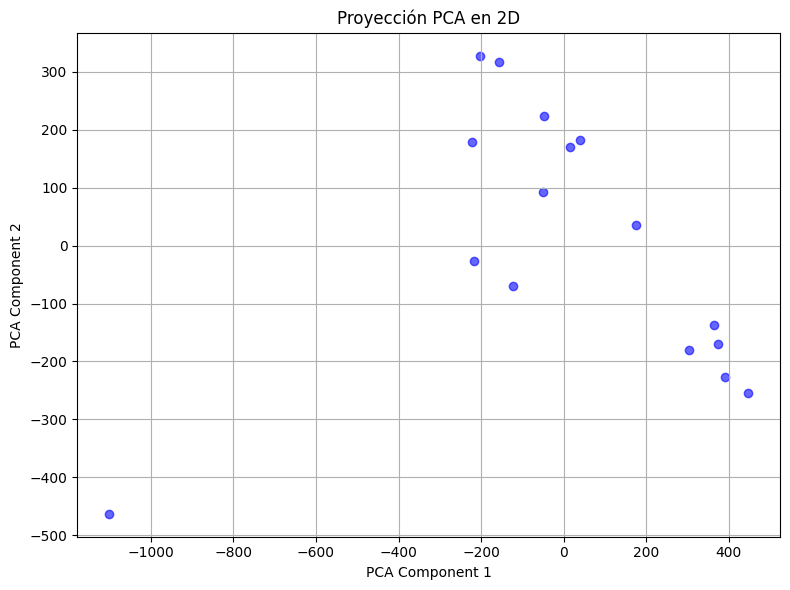

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(pr_I1[:, 0].cpu().numpy() , pr_I1[:, 1].cpu().numpy() , c='blue', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Proyección PCA en 2D")
plt.grid(True)
plt.tight_layout()
plt.show()

Next we check the dimesion of the diffenrent vectors and matrix to be sure all is aligned with what we expect

In [ ]:
print("wavelength:", lambda1.shape)
print("Intensity_centered", I1_centered.shape)
print("Covariance:", I1_covariance.shape)
print("eigenvalues:", I1_eigenvalues.shape)
print("eigenvectors:", I1_eigenvectors.shape)
print("pr_I1:", pr_I1.shape)

wavelength: torch.Size([968])
Intensity_centered torch.Size([16, 968])
Covariance: torch.Size([968, 968])
eigenvalues: torch.Size([968])
eigenvectors: torch.Size([968, 968])
pr_I1: torch.Size([16, 2])


#Loading Plots:

This plots show the loading on each λ indicates how much that λ influences the shape of the PC.

**Positive peaks**: This wavelength increase the projection of the different spectrum in the PC.

**Negative peaks**: This wavelength reduce (or increas in the oposite direction) to the projection of the different spetrum in the PC.

We created a plot for Loading in PC1, this plot show what are the wavelength regions that are most affecting PC1. The changes could be reflecting:
1. Changes in the intesity of specific Raman modes (associated to the regions) between the time.
2. Posible absortion effects or structural interference for organic samples.
3. There is a strong band in the ~1600 nm range, that vibration is probably disappearing or appearing over time or between experimental conditions.


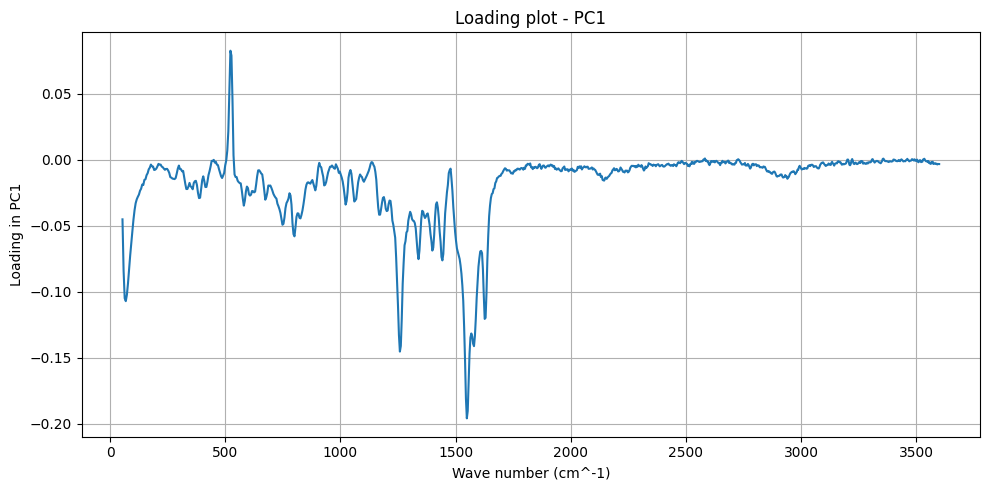

In [ ]:
# PC1 loading plot
loadings_pc1 = I1_eigenvectors[:, 0].cpu().numpy()  # PC1 → primera columna
wavelengths = lambda1.cpu().numpy()  # si es tensor

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, loadings_pc1)
plt.xlabel("Wave number (cm^-1)")
plt.ylabel("Loading in PC1")
plt.title("Loading plot - PC1")
plt.grid(True)
plt.tight_layout()
plt.show()

Same as PC1; Now we created a plot for Loading charges in PC2, this plot show what are the wavelength regions that are most affecting PC2. The changes could be reflecting:

1. It may be correcting for baseline effects.

2. It could also be detecting variations in secondary peaks or small spectral shifts.

3. Frequent alternations between positive and negative are common in PCs that reflect shape changes (peak broadening, shifting, or deformation).

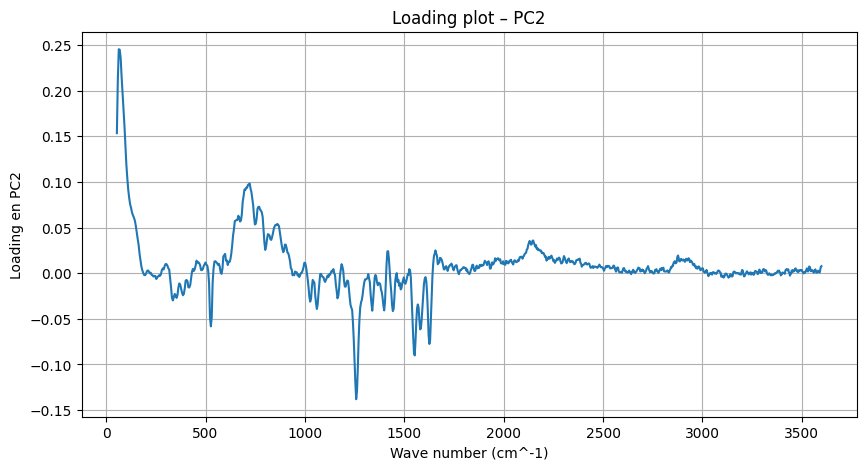

In [ ]:
# PC2 loading plot
loadings_pc2 = I1_eigenvectors[:, 1].cpu().numpy()

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, loadings_pc2)
plt.title("Loading plot – PC2")
plt.xlabel("Wave number (cm^-1)")
plt.ylabel("Loading en PC2")
plt.grid(True)
plt.show()

Next graph is showing which complete spectrum contributes the most and least to each PC.


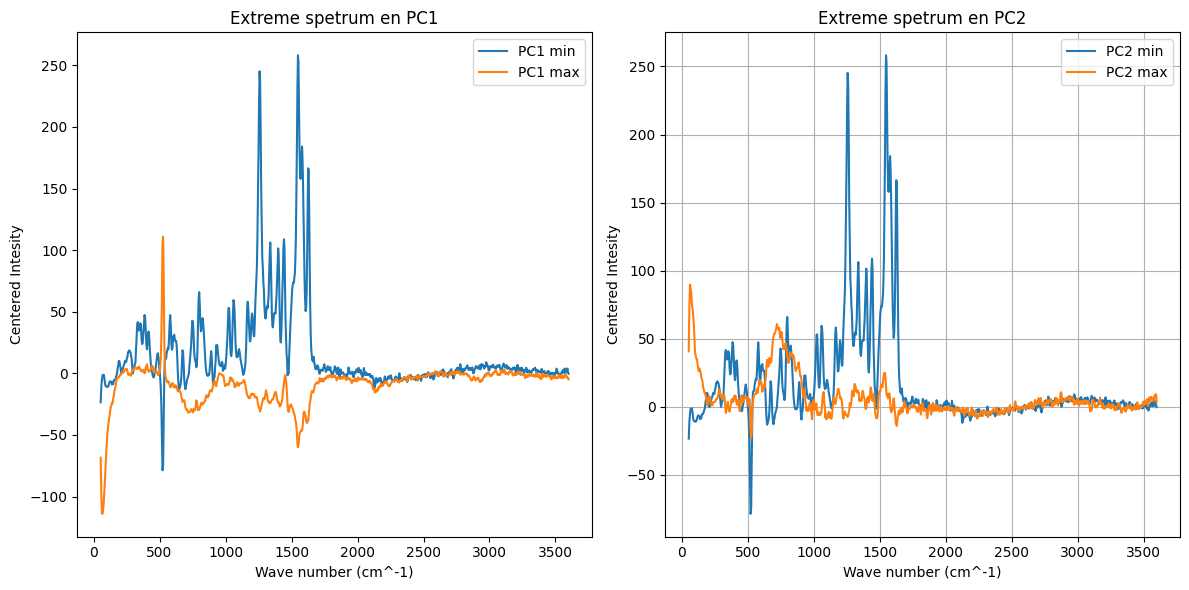

In [ ]:
# PC1 extremos
idx_pc1_min = torch.argmin(pr_I1[:, 0])
idx_pc1_max = torch.argmax(pr_I1[:, 0])

# PC2 extremos
idx_pc2_min = torch.argmin(pr_I1[:, 1])
idx_pc2_max = torch.argmax(pr_I1[:, 1])

# Graficar espectros asociados
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(wavelengths, I1_centered[idx_pc1_min].cpu(), label="PC1 min")
plt.plot(wavelengths, I1_centered[idx_pc1_max].cpu(), label="PC1 max")
plt.title("Extreme spetrum en PC1")
plt.xlabel("Wave number (cm^-1)")
plt.ylabel("Centered Intesity")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(wavelengths, I1_centered[idx_pc2_min].cpu(), label="PC2 min")
plt.plot(wavelengths, I1_centered[idx_pc2_max].cpu(), label="PC2 max")
plt.title("Extreme spetrum en PC2")
plt.xlabel("Wave number (cm^-1)")
plt.ylabel("Centered Intesity")
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()




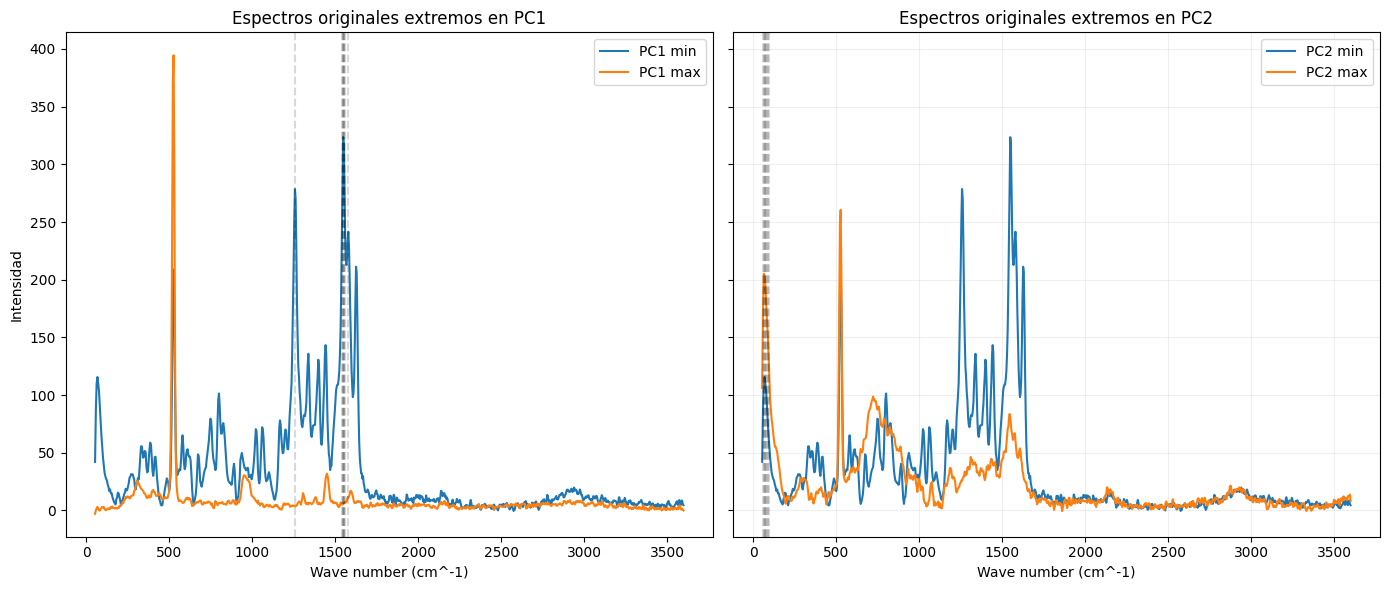

In [ ]:
# ── 1. Índices de espectros extremos en PC1 y PC2 ──────────────────────────
pc1_max_idx = torch.argmax(pr_I1[:, 0]).item()
pc1_min_idx = torch.argmin(pr_I1[:, 0]).item()
pc2_max_idx = torch.argmax(pr_I1[:, 1]).item()
pc2_min_idx = torch.argmin(pr_I1[:, 1]).item()

# ── 2. Espectros originales correspondientes ──────────────────────────────

lamdmodulin007_df.iloc[1:,pc1_max_idx]
sp_pc1_max = I1_original[pc1_max_idx].cpu().numpy()
sp_pc1_min = I1_original[pc1_min_idx].cpu().numpy()
sp_pc2_max = I1_original[pc2_max_idx].cpu().numpy()
sp_pc2_min = I1_original[pc2_min_idx].cpu().numpy()

# ── 3. Wavelengths y loadings de PC1 / PC2 ─────────────────────────────────
#wavelengths = wavelengths.cpu().numpy()
load1 = I1_eigenvectors[:, 0].cpu().numpy()
load2 = I1_eigenvectors[:, 1].cpu().numpy()

# elige las 8 λ con |carga| mayor para cada PC
top_n = 8
idx_top1 = np.argsort(np.abs(load1))[-top_n:]
idx_top2 = np.argsort(np.abs(load2))[-top_n:]

# ── 4. Gráfica ────────────────────────────────────────────────────────────
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- panel PC1
axs[0].plot(wavelengths, sp_pc1_min, label='PC1 min')
axs[0].plot(wavelengths, sp_pc1_max, label='PC1 max')
for i in idx_top1:
    axs[0].axvline(wavelengths[i], color='k', alpha=0.15, linestyle='--')
axs[0].set_title('Espectros originales extremos en PC1')
axs[0].set_xlabel('Wave number (cm^-1)')
axs[0].set_ylabel('Intensidad')
axs[0].legend()

# --- panel PC2
axs[1].plot(wavelengths, sp_pc2_min, label='PC2 min')
axs[1].plot(wavelengths, sp_pc2_max, label='PC2 max')
for i in idx_top2:
    axs[1].axvline(wavelengths[i], color='k', alpha=0.15, linestyle='--')
axs[1].set_title('Espectros originales extremos en PC2')
axs[1].set_xlabel('Wave number (cm^-1)')
axs[1].legend()

plt.tight_layout()
plt.grid(True, which='both', axis='both', alpha=0.2)
plt.show()

This graph are showing which complete spectrum contributes the most and least to each PC.

**For left site graph (PC1):**

For blue curve,*spectrum that most affects PC1*

1. we can see High intensity regions between 500-550 nm and 1200-1500 nm and backgroun signal in the region of < 300 cm^-1

For orange curve, *spectrum that less affects PC1*

2. We can see the same attenuated peaks and a more positive overall background in the UV (< 400 cm^-1).

PC1 separates “spectra with strong peaks” vs. “spectra with weak peaks/high baseline.” This may correspond to: • the concentration or presence of the resonant species • the sample transitioning from a “present” to an “off” state.

**For right site graph (PC2):**

For blue curve,*spectrum that most affects PC12*:

1. The greatest difference is in the first 0-250 cm^-1 (positive peak in orange, negative in blue).

For orange curve, *spectrum that less affects PC2*

2.  The main Raman peaks (500-1500 cm^-1) barely change; the background does.

PC2 captures baseline/fluorescence variations in the UV-blue range or subtle shifts in the continuum. It can be used to correct or explain background changes independent of vibrational peaks.

# Why we get this Raman spectra
This spectra are explining what is affecting to PC1 and PC2. So the spectra that is most afecting PC1 or PC2 is the spectra that is aligned to PC1 direction or to PC2 direction for each case. While the spectra that is les affecting PC1 or PC2 is the spectrum that is les aligned to the PC1 or PC2 direction for each case.

**This allow us to idetify the Raman spectra limits for each analysis**, this can allow us to identify what is happening in the sample (chemical reaction or physical changes)

**For example:**

If the PC1 max spectrum has more intense peaks in the amide I region, and the PC1 min spectrum does not, then PC1 could be capturing a Eu(III)-induced conformational change.

If the baseline changes on PC2, then it could be capturing fluorescence or instrument effects.

**Lanmodulin + Eu(III)**:

PC1 max spectrum could be representing the state most bound to Eu(III)

PC1 min spectrum could be representing the least bound or free state

PC2 Possible Eu(III) fluorescence or baseline.


## In general


**PC1** = "how much the main Raman peaks rise or fall ove the time, without examining each spectrum over time"

**PC2** = "how much the background/short-k fluorescence moves, independent of the peaks of interest, meaning we can ee the noise variation over the time, and there for we can have and idea of the signal to noise ratio without examine a complete serie of spectrum over the time"

This allows you to quickly monitor whether the sample is changing chemically (PC1) or if your instrument/baseline is drifting (PC2) without inspecting all 968 channels one by one.